In [1]:
import time
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
import os, errno
import glob

## compute kinematic paramters - velocity (speed and angular velocity)

In [2]:
# load centroid file wih distance and centroid data

df = pd.read_csv('./dataFolders/Output/KinematicAnalysis_v5/CentroidAndDistanceData.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_smoothened,y_smoothened,cent_x,cent_y,distance,distanceincms
0,0,0,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,L0.1_c-3_m10,last,74,310,233,0.810811,2.297297,24.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,L0.1_c-3_m10,last,74,310,233,1.013514,2.770270,30.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove Problematic Files

listProbs = pd.read_csv(r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\VideosWithMarkers\FirstLastTroubleVideos_v4\names.csv')
listProbs['name'] = listProbs['name'].str[1:]
listProbs.head()

# df.name.str.contains(df.name + '_' + df.visitNum)

,Unnamed: 0,name
0,0,L0.1_c-3_m10_firstVisit.csv
1,1,L0.1_c-3_m10_lastVisit.csv
2,2,L0.1_c-3_m12_firstVisit.csv
3,3,L0.1_c-3_m12_lastVisit.csv
4,4,L0.1_c-3_m23_lastVisit.csv


In [4]:
df['string'] = df.name + '_' + df.visit + 'Visit.csv'

sub_df= df[pd.DataFrame(df.string.tolist()).isin(listProbs.name.tolist()).any(1) == False]

In [5]:
sub_df.head()

,Unnamed: 0,Unnamed: 0.1,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_smoothened,y_smoothened,cent_x,cent_y,distance,distanceincms,string
2818,2818,2818,L0.1_c-3_m2,first,74,309,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2819,2819,2819,L0.1_c-3_m2,first,74,309,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2820,2820,2820,L0.1_c-3_m2,first,74,309,233,14.054054,16.216216,416.0,480.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2821,2821,2821,L0.1_c-3_m2,first,74,309,233,12.027027,15.777027,356.0,467.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2822,2822,2822,L0.1_c-3_m2,first,74,309,233,17.398649,15.810811,515.0,468.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv


In [6]:
df_use = sub_df.copy()
df_use[['lightLevel', 'mothID']] =  df_use['name'].str.split('_', n = 1, expand = True)
df_use = df_use.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 
                                'name',
                                'flower_x', 'flower_y',
                                'x', 'y',
                                'x_pixel', 'y_pixel',
                                'distance', 'distanceincms',
                                'string'
                                ])

In [7]:
df_use.head()

,visit,flower_r,x_smoothened,y_smoothened,cent_x,cent_y,lightLevel,mothID
2818,first,74,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2819,first,74,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2820,first,74,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2821,first,74,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2822,first,74,NaN,NaN,NaN,NaN,L0.1,c-3_m2


In [ ]:
def ztoPolar(x,y):
    r = np.sqrt(x**2+y**2)
    t = np.arctan2(y,x)
    return(r,t)

In [10]:
from scipy.interpolate import UnivariateSpline

def interpolateCubic(timeseries, sf):
    t = np.asarray(np.arange(0, len(timeseries)))
    w = np.isnan(timeseries)
    y = timeseries.copy()
    y[w] = 0.

    spl = UnivariateSpline(t, y, w=~w)
    spl.set_smoothing_factor(sf)
    test = spl(t)
    test[w] = np.nan
    return(test)

In [11]:
sf = 20 # set smoothening factor for cubic spline interpolation

In [12]:
figpath = './dataFolders/Output/KinematicAnalysis_v5/Figures/radialPosition/'

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppDa

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\projections\polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
C:\Users\Tanvi\AppDa

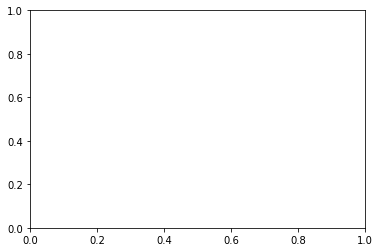

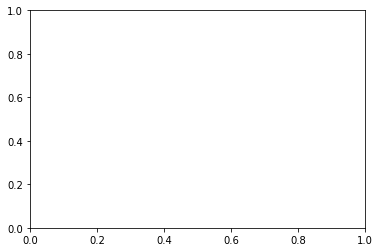

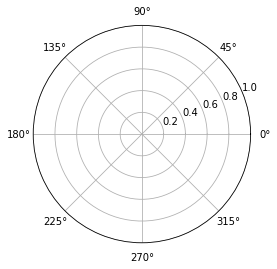

In [36]:
light = []
visit = []
mothID = []
radialDist = []
speed_ = []
acc_ = []
theta = []
ang_vel = []
ang_acc = []

f1, ax1 = plt.subplots()
f2, ax2 = plt.subplots()
f3, ax3 = plt.subplots()
ax3 = plt.subplot(projection = 'polar')

for l, light_sub in df_use.groupby('lightLevel'):
    for v, visit_sub in light_sub.groupby('visit'):
        for m, moth_sub in visit_sub.groupby('mothID'):
            x = moth_sub.loc[:,'x_smoothened'].values
            y = moth_sub.loc[:,'y_smoothened'].values
            r,t = ztoPolar(x,y)
            
            radius = moth_sub.flower_r.unique()
            cent_x = moth_sub.loc[:,'cent_x'].values*2.5/radius
            cent_y = moth_sub.loc[:,'cent_y'].values*2.5/radius
            cent_r,cent_t = ztoPolar(cent_x,cent_y)
            s_cent_r = interpolateCubic(cent_r, sf)
            speed = np.gradient(s_cent_r)
            acc = np.gradient(speed)
            
            s_cent_t = interpolateCubic(cent_t, sf)
            angular_speed = np.gradient(s_cent_t)
            angular_acc = np.gradient(angular_speed)
            
            # save all relevant variables
            
            light.extend([l]*len(moth_sub))
            visit.extend([v]*len(moth_sub))
            mothID.extend([m]*len(moth_sub))
            
            radialDist.extend(s_cent_r)
            speed_.extend(speed)
            acc_.extend(acc)
            theta.extend(s_cent_t)
            ang_vel.extend(angular_speed)
            ang_acc.extend(angular_acc)           
                        
            # plot various things
            name = l + '_' + v + '_' + m
            ax1.plot(cent_r, 'ro', ms = 2)
            ax1.plot(s_cent_r, 'g')
            f1.savefig(figpath + 'Position/' + name + '.pdf')
            ax1.cla()
            
            ax2.plot(cent_t*180/np.pi, 'ro', ms = 2)
            ax2.plot(s_cent_t*180/np.pi, 'g')
            f2.savefig(figpath + 'Theta/' + name + '.pdf')
            ax2.cla()
            
# #             plt.figure('polar')
            ax3.plot(cent_t, cent_r)
            f3.savefig(figpath + 'Polar/' + name + '.pdf')
            ax3.cla()        

In [38]:
final_df = pd.DataFrame({'lightLevel': light,
                         'visit': visit,
                         'mothID': mothID,
                         'r': radialDist,
                         'speed' : speed_,
                         'acceleration': acc_,
                         'theta': theta,
                         'angular_speed': ang_vel,
                         'angular_acc': ang_acc})

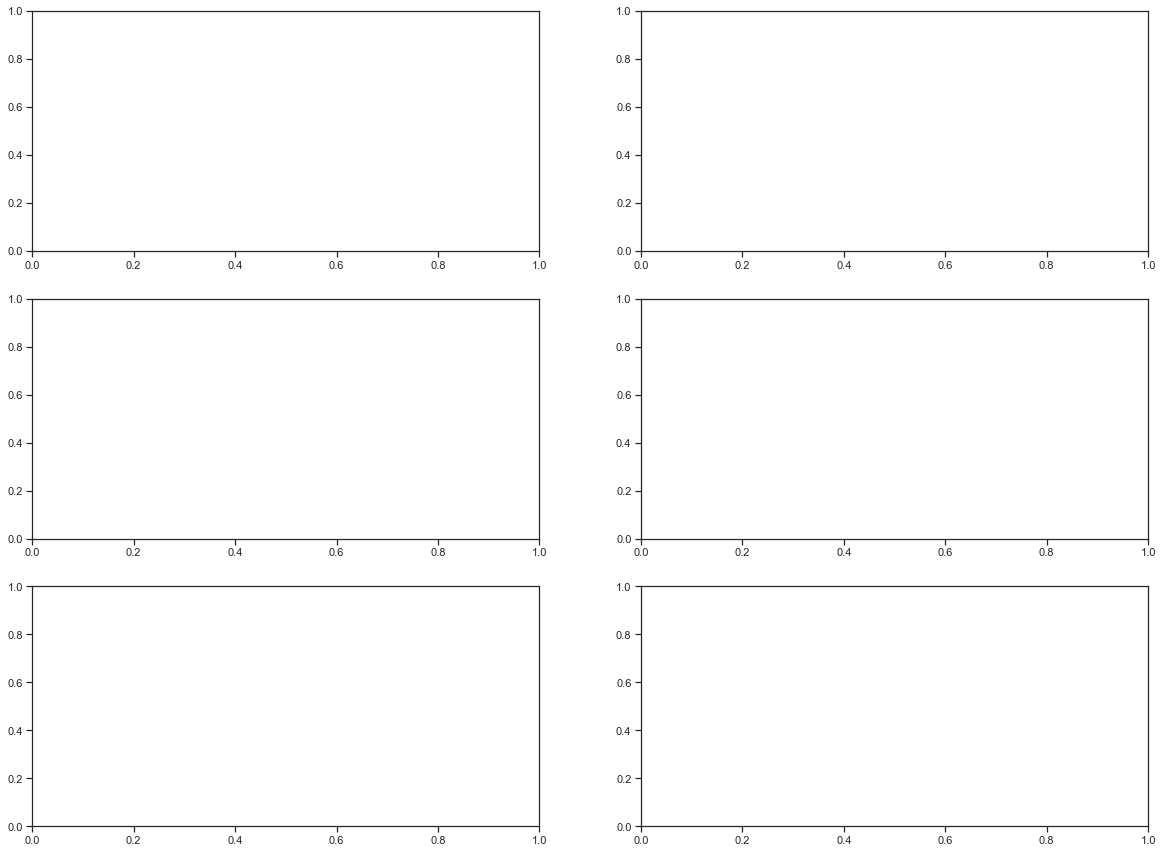

In [67]:
f, ax = plt.subplots(3,2, figsize = (20,15))

for l, light_df in final_df.groupby('lightLevel'):
    for v, visit_df in light_df.groupby('visit'):
        for m, moth_df in visit_df.groupby('mothID'):
                        
            ax[0,0].plot(moth_df.r)
            ax[1,0].plot(moth_df.speed, 'r')
            ax[2,0].plot(moth_df.acceleration, 'k')

            ax[0,1].plot(moth_df.theta*180/np.pi)
            ax[1,1].plot(moth_df.angular_speed*180/np.pi, 'r')
            ax[2,1].plot(moth_df.angular_acc*180/np.pi, 'k')
            
            name = l + '_' + v + '_' + m
            f.savefig(figpath + 'Derivatives/' + name + '.pdf')
            for axes in ax.ravel():
                axes.cla()

In [49]:
u = []
a = []
l_ = []
v_ = []
m_ = []

for l, light_df in final_df.groupby('lightLevel'):
    for v, visit_df in light_df.groupby('visit'):
        for m, moth_df in visit_df.groupby('mothID'):
            av_u = np.nanmedian(abs(moth_df.speed))
            av_a = np.nanmedian(abs(moth_df.acceleration))
            
            u.append(av_u)
            a.append(av_a)
            l_.append(l)
            v_.append(v)
            m_.append(m)         
            
summary_df = pd.DataFrame({'lightLevel': l_,
                          'visit': v_,
                          'mothID': m_,
                          'speed': u,
                          'acceleration': a})

In [50]:
summary_df

,lightLevel,visit,mothID,speed,acceleration
0,L0.1,first,c-3_m2,0.025810,0.002422
1,L0.1,first,c-3_m20,0.021211,0.001747
2,L0.1,first,c-3_m21,0.060581,0.001602
3,L0.1,first,c-3_m22,0.032537,0.000201
4,L0.1,first,c-3_m23,0.047328,0.003345
...,...,...,...,...,...
70,L50,last,c-3_m37,0.066487,0.005424
71,L50,last,c-3_m38,0.031172,0.001791
72,L50,last,c-3_m39,0.030283,0.002412
73,L50,last,c-3_m45,0.025025,0.003068


In [51]:
colorScheme = {'L0.1':plt.cm.Purples_r, 'L50':plt.cm.Oranges_r}

In [52]:
import seaborn as sns
sns.set(style="ticks")
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 8

w = 7/3
# w = 8
h = w * 2

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


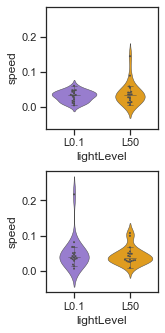

In [68]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0
for v, sub in summary_df.groupby('visit'):
    sns.violinplot(x='lightLevel', y='speed', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='speed', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='speed', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])

#     plt.ylim(-1.5,15)
#     ax.xaxis.grid(False)
#     plt.yticks(size = 8)
#     plt.xticks([0,1], size = 8)
#     plt.xlabel('Light Level', size = 8)
#     plt.ylabel('Distance From Nectary (cm)', size = 8)
#     sns.despine(trim=True, left=True)
    i+=1
plt.tight_layout()
plt.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/speed.pdf')

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


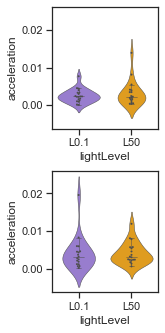

In [69]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0
for v, sub in summary_df.groupby('visit'):
    sns.violinplot(x='lightLevel', y='acceleration', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='acceleration', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='acceleration', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])

#     plt.ylim(-1.5,15)
#     ax.xaxis.grid(False)
#     plt.yticks(size = 8)
#     plt.xticks([0,1], size = 8)
#     plt.xlabel('Light Level', size = 8)
#     plt.ylabel('Distance From Nectary (cm)', size = 8)
#     sns.despine(trim=True, left=True)
    i+=1
plt.tight_layout()
plt.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/Acceleration.pdf')

In [57]:
low_first = summary_df[(summary_df.lightLevel == 'L0.1') & (summary_df.visit == 'first')].speed.values
high_first = summary_df[(summary_df.lightLevel == 'L50') & (summary_df.visit == 'first')].speed.values

low_last = summary_df[(summary_df.lightLevel == 'L0.1') & (summary_df.visit == 'last')].speed.values
high_last = summary_df[(summary_df.lightLevel == 'L50') & (summary_df.visit == 'last')].speed.values

In [58]:
from scipy import stats

stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=184.0, pvalue=0.44955997838704864)

In [59]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=148.0, pvalue=0.33464556330904455)

In [60]:
low_first = summary_df[(summary_df.lightLevel == 'L0.1') & (summary_df.visit == 'first')].acceleration.values
high_first = summary_df[(summary_df.lightLevel == 'L50') & (summary_df.visit == 'first')].acceleration.values

low_last = summary_df[(summary_df.lightLevel == 'L0.1') & (summary_df.visit == 'last')].acceleration.values
high_last = summary_df[(summary_df.lightLevel == 'L50') & (summary_df.visit == 'last')].acceleration.values

In [61]:
from scipy import stats

stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=175.0, pvalue=0.35185416279409254)

In [62]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=144.0, pvalue=0.28990047352905324)